# Identifying Predicting Factors of Tobacco Use in the Youth
(Exploratory Data Analysis and Data Preproccessing)

# Environment Setup (Do this before running any code cell)
1. While in VSCode, use command `cmd+shift+p` 
2. Select `Python: Create Environment` -> `Venv`. This will create a python venv to install all your python packages in. After creating it VSCode will automatically active it.
3. Run command in **Install Packages** below to automatically install all required packages from the `requirements.txt` file.

### Install Packages
Install all the required packages directly from the requirements.txt file

In [289]:
# Run this to install required packages
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Global Imports
Import everything you need

In [290]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))
from helpers.drop_list import dropped


# Load the dataset
df = pd.read_csv('../data/nyts2023.csv')
tobacco_user_df = pd.read_csv('../data/tobacco_users.csv')
nonuser_df = pd.read_csv('../data/nonusers.csv')

/var/folders/4z/n7sr27qx5h18n91g81tmnsdh0000gn/T/ipykernel_66857/3635841.py:12: DtypeWarning: Columns (690,691,692,703,706,708,709,710,711,712,713,714,715,716,717,718,719,720,721,1172,1174,1185,1214) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/nyts2023.csv')
/var/folders/4z/n7sr27qx5h18n91g81tmnsdh0000gn/T/ipykernel_66857/3635841.py:13: DtypeWarning: Columns (690,691,692,703,706,1185,1214,1247,1266,1285,1287,1298,1299,1303) have mixed types. Specify dtype option on import or set low_memory=False.
  tobacco_user_df = pd.read_csv('../data/tobacco_users.csv')
/var/folders/4z/n7sr27qx5h18n91g81tmnsdh0000gn/T/ipykernel_66857/3635841.py:14: DtypeWarning: Columns (690,691,692,703,704,1172,1173,1174,1185,1214) have mixed types. Specify dtype option on import or set low_memory=False.
  nonuser_df = pd.read_csv('../data/nonusers.csv')


### Update requirements.txt
If you install any new packages, run this update the requirements.txt file.

In [291]:
%pip freeze > ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Selected Target Variable
The target label for our model will be a binary classification of tobacco user or non-user. This label is based on Q100: "During the past 30 days, on how many days did you use any tobacco product(s)?". Respondents with a response value of 1 or greater will be labeled as tobacco users. Respondents either skipped Q100 or reported a value of 0 will be labeled as nonusers.

In [292]:
# Filter out rows where Q100 is either 0, skipped, or missing
# Keep only rows where Q100 has a numeric value of 1 or greater, indicating Tobacco Use

tobacco_user_df = df[df['Q100'].apply(lambda x: str(x).isdigit() and int(x) >= 1)]

# Count the number of respondents who use Tobacco
num_respondents = len(tobacco_user_df)
print(f"Number of respondents who use Tobacco: {num_respondents}")

# Create a DataFrame for non-users by negating the condition for tobacco use
nonuser_df = df[~df['Q100'].apply(lambda x: str(x).isdigit() and int(x) >= 1)]

# Count the number of respondents who do not use Tobacco
num_respondents_non = len(nonuser_df)
print(f"Number of respondents who do not use Tobacco: {num_respondents_non}")

# Export the filtered data to new CSV files
tobacco_user_df.to_csv('tobacco_users.csv', index=False)
nonuser_df.to_csv('nonusers.csv', index=False)
print("Export Success.")

Number of respondents who use Tobacco: 1760
Number of respondents who do not use Tobacco: 20309
Export Success.


# Data Visualization

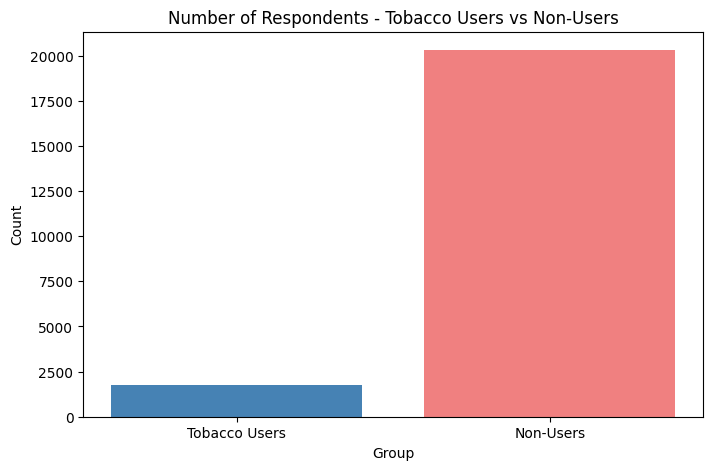

In [293]:
#comparison between tobacco users and non-users
user_counts = [len(tobacco_user_df), len(nonuser_df)]
labels = ['Tobacco Users', 'Non-Users']

plt.figure(figsize=(8, 5))
plt.bar(labels, user_counts, color=['steelblue', 'lightcoral'])
plt.title('Number of Respondents - Tobacco Users vs Non-Users')
plt.xlabel('Group')
plt.ylabel('Count')
plt.show()

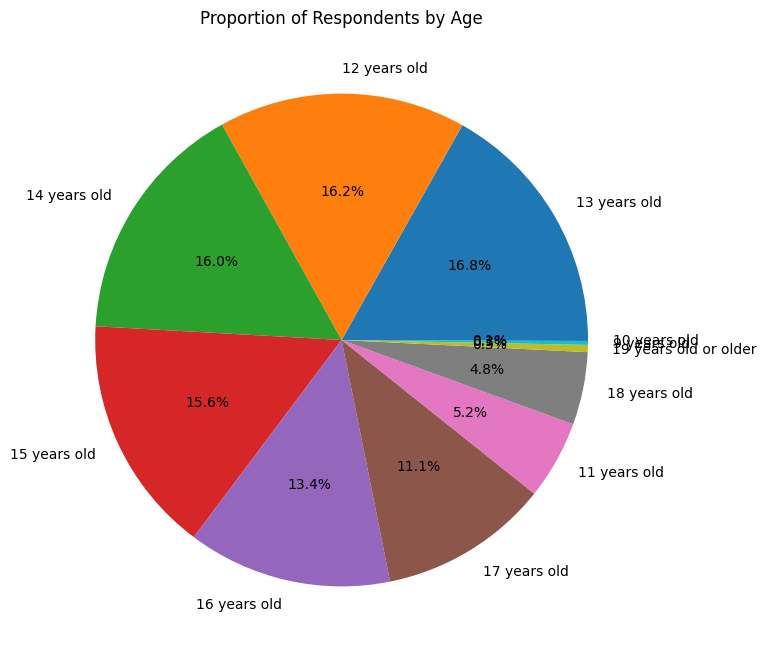

In [294]:
age_mapping = {
    1: '9 years old',
    2: '10 years old',
    3: '11 years old',
    4: '12 years old',
    5: '13 years old',
    6: '14 years old',
    7: '15 years old',
    8: '16 years old',
    9: '17 years old',
    10: '18 years old',
    11: '19 years old or older'
}

#showing actual ages instead of index
df['age_labeled'] = df['QN1'].map(age_mapping)

#plotting the proportion of respondents by age
df['age_labeled'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
plt.title('Proportion of Respondents by Age')
plt.ylabel('')
plt.show()


# Exploratory Data Analysis
For this phase I didn't do much visualizes I just did a manual deep dive through the questions so far and took the notes below. I created two files `map.py` and `map_annotated.py` containing the original mapping of questions to columnID and an annotated version where I decided to note which columns should be merged, one-hot encoded, or just removed. 

**Notes:**
- Many multiple choice questions are already split into separate columns and do not need to be one-hot encoded. But remove any Dummy Variable Trap questions.
- Questions that are noted as Categorical need to be one-hot encoded. For example, for QN1, the categories are 0-13, 14-18, 19+, each question needs to be it's own column and have 0 or 1 if they belong to that group.
- MERGE to NC means merge to new column, TC = target column
  - A MERGE means that if they answered to any of these questions, their value to the new question would be 1. If they didn't answer to any of these questions, their value would be 0.
- Questions like "Why do you currently use e-cigarettes? (They are available in flavors, such as menthol, mint, candy, fruit, or chocolate)" can be thought of as 
  "Responded used e-cigarettes due to it's availability in flavors such as menthol, mint, candy, fruit, or chocolate".
- Skip Logic Questions don't really seem to be a problem as question answers are split into separate columns (as if they were one-hot encoded already) and dummy variable traps can be removed.
  All other questions can seemingly be one-hot encoded (split into categories), merged (multiple of them) into new columns, or just removed because they are nto relevant to the analysis.
  - The few exceptions of skip logic questions are ones that are removed anyways
- Some questions like 48-51 on their own are weird to predict if they relate to tobacco use. For example (Q48) if you are curious about trying a cig
  it wouldnt be significant to predict if you are a tobacco user. But if you combined it with smoking in the household, it could be significant, ex.
  'Respondent is curious about smoking and is exposed to it within the household'. Just a suggestion.
- In hindsight, i overlooked the importance of people potentially using flavored nicotine products vs non-flavored.
- Used Q39 and Q100,101 as target label

After that I decided to do some data cleaning.

# Preliminary Data Preprocessing

##### Remove unneccessary rows (manually determined)

In [295]:
# Drop columns that are not needed, in 'drop_list' and ignore any missing columns
df_new = df.drop(columns=dropped, errors='ignore')

# Calculate the number of columns before and after dropping
original_column_count = df.shape[1]
new_column_count = df_new.shape[1]
columns_dropped = original_column_count - new_column_count

# Print the result
print(f"Number of columns dropped: {columns_dropped}")
print(f"Original columns: {original_column_count}, New columns: {new_column_count}")

Number of columns dropped: 550
Original columns: 1470, New columns: 920


##### Remove all rows that have a TEXT value response.

In [296]:
# Step 2: Identify and drop columns that contain 'TEXT' in their column IDs
text_columns = [col for col in df_new.columns if 'TEXT' in col]
df_new_notext = df_new.drop(columns=text_columns, errors='ignore')

# Calculate and print the result for 'TEXT' columns
original_column_count = df_new.shape[1]
new_column_count = df_new_notext.shape[1]
columns_dropped = original_column_count - new_column_count

# Print the result
print(f"Number of columns dropped: {columns_dropped}")
print(f"Original columns: {original_column_count}, New columns: {new_column_count}")

df_new_notext.head()

Number of columns dropped: 53
Original columns: 920, New columns: 867


,artificial_id,Non_SOGI_School,Location,QN1,QN2,QN3,QN4b,QN4c,QN4d,QN4e,...,CHTP,CPOUCH,Stratum,Stratum_num,PSU,PSU_num,WT_analysis,QN141R,QN142R,age_labeled
0,B2100007,2,1.0,5.0,2.0,2.0,NaN,NaN,NaN,NaN,...,2.0,2.0,S05,5,P21,21,4232.149929,NaN,NaN,13 years old
1,B2100018,2,2.0,8.0,2.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,S02,2,P09,9,514.656322,NaN,NaN,16 years old
2,B2100021,2,1.0,5.0,1.0,2.0,1.0,NaN,NaN,NaN,...,NaN,NaN,S08,8,P32,32,244.855983,NaN,NaN,13 years old
3,B2100035,2,1.0,4.0,2.0,2.0,NaN,NaN,NaN,NaN,...,NaN,2.0,S08,8,P34,34,775.983192,NaN,NaN,12 years old
4,B2100036,2,1.0,4.0,2.0,1.0,NaN,NaN,NaN,NaN,...,2.0,2.0,S04,4,P16,16,353.735565,1.0,1.0,12 years old


##### Check for and display all columns with missing values. 
Select `View as a scrollable element` to exit truncated view see all columns. By displaying all the columns with missing values and their counts, we can see which ones are due to a skip because a previous question disqualified them from this one or the question not applying to them: they are the ones with the very high amount of missing values per question / column. The smaller amounts are most often because of edit errors or just not answered / not displayed (what does that mean?)

In [297]:
pd.set_option('display.max_rows', None)
df_new_notext.isnull().sum()

artificial_id          0
Non_SOGI_School        0
Location              69
QN1                   90
QN2                  152
QN3                   76
QN4b               18205
QN4c               21564
QN4d               21883
QN4e               19790
QN5a               19631
QN5b               19176
QN5c               17828
QN5d               21377
QN5e                9636
QN6                  184
QN7                18705
QN8                18742
QN9                18791
QN11a              20404
QN11b              21285
QN11e              21889
QN11f              21890
QN11l              21298
QN12a              21639
QN12b              21890
QN12e              21949
QN12f              22009
QN12h              21841
QN12l              21470
QN14j              21893
QN16               20561
QN17               20565
QN18e_a            22043
QN18e_b            22017
QN18e_c            21958
QN18e_d            22034
QN18e_e            22023
QN18e_f            22043
QN18e_g            22039


##### Convert all columns to numerical format

In [298]:
# Check if any columns contain numeric-like data stored as strings (do not run yet! WIP) 
for column in df.columns:
    # Ensure the column is of object (string-like) type
    if df[column].dtype == 'object':
        # Now safely apply the str accessor
        if df[column].str.isnumeric().any():
            print(f"Column {column} contains numeric-like data but is stored as a string.")

Column Q1 contains numeric-like data but is stored as a string.
Column Q2 contains numeric-like data but is stored as a string.
Column Q3 contains numeric-like data but is stored as a string.
Column Q4a contains numeric-like data but is stored as a string.
Column Q4b contains numeric-like data but is stored as a string.
Column Q4c contains numeric-like data but is stored as a string.
Column Q4d contains numeric-like data but is stored as a string.
Column Q4e contains numeric-like data but is stored as a string.
Column Q5a contains numeric-like data but is stored as a string.
Column Q5b contains numeric-like data but is stored as a string.
Column Q5c contains numeric-like data but is stored as a string.
Column Q5d contains numeric-like data but is stored as a string.
Column Q5e contains numeric-like data but is stored as a string.
Column Q6 contains numeric-like data but is stored as a string.
Column Q7 contains numeric-like data but is stored as a string.
Column Q8 contains numeric-lik

Now convert all string data into numerical data:

In [299]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

for column in df.columns:
    # Ensure the column is of object (string-like) type
    if df[column].dtype == 'object':
        # Check if it contains numeric-like data stored as strings
        if df[column].str.isnumeric().any():
            # Convert numeric-like strings to actual numbers
            df[column] = pd.to_numeric(df[column], errors='coerce')
        else:
            # Convert categorical strings to numerical labels using LabelEncoder
            df[column] = label_encoder.fit_transform(df[column])

print("All string-based categorical columns have been converted to numerical values.")

All string-based categorical columns have been converted to numerical values.


Verify all string based columns have been converted to numerical values

In [300]:
for column in df.columns:
    # Ensure the column is of object (string-like) type
    if df[column].dtype == 'object':
        # Now safely apply the str accessor
        if df[column].str.isnumeric().any():
            print(f"Column {column} contains numeric-like data but is stored as a string.")

# To Do:
- Make appropriate transformations in map_annotated before handling missing values.
  1. Merge columns together into new columns and drop all the old ones that were previously separate. Similar columns become one umbrella column. Ex. "Respondent used e-cigarettes due to exposure from friends, media, or family" encompasses multiple columns and reduces dimensions.
  2. Use one-hot encoding to separate a categorical labeled columns into separate columns for each category. Ex. Ages 0-13, 14-18, 19+ become their own categories.
  3. Consider combining attributes together that aren't necessarily similar but may be correlated.
- Then handle missing values with a high missing rate by replacing it with 0. The reasoning is because:

In the case of QN4: "QN4B: Are you Hispanic, Latino, Latina, or of Spanish origin? (Yes, Mexican, Mexican American, Chicano, or Chicana)" a missing response indicates that they are not what the question is asking.
So in cases like such, you would not use a median or mean value as it's only 1 or No response (Yes or No).
You would also not just drop the column because over 50% of participants left it empty. It just means that 50% or more of participants are not what the question is asking. 
 
Another example is QN7: "QN7: How old were you when you first used an e-cigarette, even once or twice?". This also has a very high number of missing values for this column. That is because the previous question asks if you have ever used it. So all those who indicated no would skip this question. 0 would represent an absence of the behavior of using an e-cigarette.

Assuming the first model we use is multilinear regression, we would ideally want all values to be binary (0/1), so these processes such as one hot encoding and merging and replacing values with 0 after strategically dropping irrelevant columns is preparing us for that.


Merging columns into new columns and drop old columns:

# NC1:

In [301]:
#before merging
qn11_columns = ['QN11a', 'QN11b', 'QN11f']  
qn12_columns = ['QN12a', 'QN12b', 'QN12f']  
print("Before NC1 Column Creation:")
print(df[qn11_columns + qn12_columns].tail())

Before NC1 Column Creation:
       QN11a  QN11b  QN11f  QN12a  QN12b  QN12f
22064    NaN    NaN    NaN    NaN    NaN    NaN
22065    NaN    NaN    NaN    NaN    NaN    NaN
22066    NaN    NaN    NaN    NaN    NaN    NaN
22067    NaN    NaN    NaN    NaN    NaN    NaN
22068    1.0    1.0    1.0    1.0    1.0    1.0


In [302]:
def check_influence(row):
    # if there is a value in those two columns it means they are influenced
    if row[qn11_columns + qn12_columns].any(): 
        #we can return 1 to indicate influence
        return "1"
    # and 0 for no influence
    # returning zero here, we can also fill NA values alongside
    else:
        return "0"

# Apply the function to create a new Influence column
df['NC1'] = df.apply(check_influence, axis=1)

/var/folders/4z/n7sr27qx5h18n91g81tmnsdh0000gn/T/ipykernel_66857/2135280707.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['NC1'] = df.apply(check_influence, axis=1)


In [303]:
#after merging:
print("After NC1 Column Creation:")
print(df[qn11_columns + qn12_columns + ['NC1']].tail())

After NC1 Column Creation:
       QN11a  QN11b  QN11f  QN12a  QN12b  QN12f NC1
22064    NaN    NaN    NaN    NaN    NaN    NaN   0
22065    NaN    NaN    NaN    NaN    NaN    NaN   0
22066    NaN    NaN    NaN    NaN    NaN    NaN   0
22067    NaN    NaN    NaN    NaN    NaN    NaN   0
22068    1.0    1.0    1.0    1.0    1.0    1.0   1


then we can drop those columns:

In [304]:
# List of columns used for the first NC1 merge
nc1_columns = ['QN11a', 'QN11b', 'QN11b', 'QN12a', 'QN12b', 'QN12f']

# Drop these columns from the DataFrame
df = df.drop(columns=nc1_columns)



# NC2

In [305]:
#before merge
nc2_columns = ['QN12l']

print("Before NC2 Column Creation:")
print(df[nc2_columns].tail())

Before NC2 Column Creation:
       QN12l
22064    1.0
22065    NaN
22066    NaN
22067    NaN
22068    1.0


In [306]:
def check_mental_state(row):
    if row[nc2_columns].any():
        return "1"  # Bad mental state present
    else:
        return "0"  # No bad mental state

# Apply the function to create NC2
df['NC2'] = df.apply(check_mental_state, axis=1)
# After merging, display NC2 column alongside related columns
print("After NC2 Column Creation:")
print(df[nc2_columns + ['NC2']].tail())


After NC2 Column Creation:
       QN12l NC2
22064    1.0   1
22065    NaN   0
22066    NaN   0
22067    NaN   0
22068    1.0   1


/var/folders/4z/n7sr27qx5h18n91g81tmnsdh0000gn/T/ipykernel_66857/341030039.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['NC2'] = df.apply(check_mental_state, axis=1)


In [307]:

columns_to_drop = ['QN12c', 'QN12d', 'QN12e', 'QN12g', 'QN12h', 'QN12i', 'QN12j', 'QN12k', 'QN12l','QN12m', 'QN12n']

# Drop these columns from the DataFrame
df = df.drop(columns=columns_to_drop)

# NC3

In [308]:
#before merging
qn16_columns = ['QN16']  
qn17_columns = ['QN17']  
print("Before NC3 Column Creation:")
print(df[qn16_columns + qn17_columns].tail())

Before NC3 Column Creation:
       QN16  QN17
22064   2.0   2.0
22065   NaN   NaN
22066   NaN   NaN
22067   NaN   NaN
22068   2.0   3.0


In [309]:

nc3_columns = qn16_columns + qn17_columns

# Define the function to check for nicotine use
def check_nicotine_use(row):
    if row[nc3_columns].any():  # Checks if there's any value in QN16 or QN17
        return "1"
    else:
        return "0"

# Apply the function to create NC3
df['NC3'] = df.apply(check_nicotine_use, axis=1)


/var/folders/4z/n7sr27qx5h18n91g81tmnsdh0000gn/T/ipykernel_66857/1778651220.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['NC3'] = df.apply(check_nicotine_use, axis=1)


In [310]:
print("After NC3 Column Creation:")
print(df[qn16_columns + qn17_columns + ['NC3']].tail())


After NC3 Column Creation:
       QN16  QN17 NC3
22064   2.0   2.0   1
22065   NaN   NaN   0
22066   NaN   NaN   0
22067   NaN   NaN   0
22068   2.0   3.0   1


now we drop the rest of the columns

In [311]:
df = df.drop(columns=nc3_columns)


# Now merging NC4

In [312]:
# Define columns for NC4, including QN77
nc4_columns = ['QN18e_a', 'QN18e_b', 'QN18e_c', 'QN18e_d', 'QN18e_e', 
               'QN18e_f', 'QN18e_g', 'QN18e_h', 'QN18e_i', 'QN18e_j', 'QN18e_k', 'QN77']

print("Before NC4 Column Creation:")
print(df[nc4_columns].tail())


Before NC4 Column Creation:
       QN18e_a  QN18e_b  QN18e_c  QN18e_d  QN18e_e  QN18e_f  QN18e_g  QN18e_h  \
22064      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
22065      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
22066      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
22067      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
22068      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

       QN18e_i  QN18e_j  QN18e_k  QN77  
22064      NaN      NaN      NaN   2.0  
22065      NaN      NaN      NaN   2.0  
22066      NaN      NaN      NaN   2.0  
22067      NaN      NaN      NaN   2.0  
22068      NaN      NaN      NaN   2.0  


In [313]:
def check_nicotine_pouch_use(row):
    # If there's a value in any nc4_columns, it indicates nicotine pouch use
    if row[nc4_columns].any():
        return "1"  # Nicotine pouch use present
    else:
        return "0"  # No nicotine pouch use
    

# Apply the function to create NC4
df['NC4'] = df.apply(check_nicotine_pouch_use, axis=1)


print("After NC4 Column Creation:")
print(df[nc4_columns + ['NC4']].tail())



After NC4 Column Creation:
       QN18e_a  QN18e_b  QN18e_c  QN18e_d  QN18e_e  QN18e_f  QN18e_g  QN18e_h  \
22064      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
22065      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
22066      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
22067      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
22068      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

       QN18e_i  QN18e_j  QN18e_k  QN77 NC4  
22064      NaN      NaN      NaN   2.0   1  
22065      NaN      NaN      NaN   2.0   1  
22066      NaN      NaN      NaN   2.0   1  
22067      NaN      NaN      NaN   2.0   1  
22068      NaN      NaN      NaN   2.0   1  


/var/folders/4z/n7sr27qx5h18n91g81tmnsdh0000gn/T/ipykernel_66857/3068098798.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['NC4'] = df.apply(check_nicotine_pouch_use, axis=1)


Drop the rest of the columns that were used to create NC4

In [314]:
df = df.drop(columns=nc4_columns)


# Now merging NC5

In [315]:
# Define columns for NC5, including QN83
nc5_columns = ['QN18f_a', 'QN18f_b', 'QN18f_c', 'QN18f_d', 'QN18f_e', 
               'QN18f_f', 'QN18f_g', 'QN18f_h', 'QN18f_i', 'QN18f_j', 'QN18f_k', 'QN83']

print("Before NC5 Column Creation:")
print(df[nc5_columns].tail())


Before NC5 Column Creation:
       QN18f_a  QN18f_b  QN18f_c  QN18f_d  QN18f_e  QN18f_f  QN18f_g  QN18f_h  \
22064      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
22065      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
22066      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
22067      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
22068      NaN      NaN      NaN      NaN      NaN      1.0      NaN      NaN   

       QN18f_i  QN18f_j  QN18f_k  QN83  
22064      NaN      NaN      NaN   2.0  
22065      NaN      NaN      NaN   2.0  
22066      NaN      NaN      NaN   2.0  
22067      NaN      NaN      NaN   2.0  
22068      NaN      NaN      NaN   1.0  


In [316]:
def check_oral_nicotine_use(row):
    # If there's a value in any nc5_columns, it indicates oral nicotine use
    if row[nc5_columns].any():
        return "1"  # Oral nicotine use present
    else:
        return "0"  # No oral nicotine use


# Apply the function to create NC5
df['NC5'] = df.apply(check_oral_nicotine_use, axis=1)

print("After NC5 Column Creation:")
print(df[nc5_columns + ['NC5']].tail())


After NC5 Column Creation:
       QN18f_a  QN18f_b  QN18f_c  QN18f_d  QN18f_e  QN18f_f  QN18f_g  QN18f_h  \
22064      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
22065      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
22066      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
22067      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
22068      NaN      NaN      NaN      NaN      NaN      1.0      NaN      NaN   

       QN18f_i  QN18f_j  QN18f_k  QN83 NC5  
22064      NaN      NaN      NaN   2.0   1  
22065      NaN      NaN      NaN   2.0   1  
22066      NaN      NaN      NaN   2.0   1  
22067      NaN      NaN      NaN   2.0   1  
22068      NaN      NaN      NaN   1.0   1  


/var/folders/4z/n7sr27qx5h18n91g81tmnsdh0000gn/T/ipykernel_66857/64211576.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['NC5'] = df.apply(check_oral_nicotine_use, axis=1)


Drop the columns that made NC5

In [317]:
df = df.drop(columns=nc5_columns)


# Now merging NC6

In [318]:
# Define columns for NC6
nc6_columns = ['QN21a_a', 'QN21a_b', 'QN21a_c', 'QN21a_d', 'QN21a_e', 
               'QN21a_f', 'QN21a_g']

print("Before NC6 Column Creation:")
print(df[nc6_columns].tail())


Before NC6 Column Creation:
       QN21a_a  QN21a_b  QN21a_c  QN21a_d  QN21a_e  QN21a_f  QN21a_g
22064      NaN      NaN      NaN      NaN      NaN      1.0      NaN
22065      NaN      NaN      NaN      NaN      NaN      NaN      NaN
22066      NaN      NaN      NaN      NaN      NaN      NaN      NaN
22067      NaN      NaN      NaN      NaN      NaN      NaN      NaN
22068      1.0      1.0      1.0      1.0      1.0      1.0      1.0


In [319]:
def check_ecig_access(row):
    # If there's a value in any nc6_columns, it indicates e-cigarette access
    if row[nc6_columns].any():
        return "1"  # E-cigarette access present
    else:
        return "0"  # No e-cigarette access


# Apply the function to create NC6
df['NC6'] = df.apply(check_ecig_access, axis=1)

print("After NC6 Column Creation:")
print(df[nc6_columns + ['NC6']].tail())


After NC6 Column Creation:
       QN21a_a  QN21a_b  QN21a_c  QN21a_d  QN21a_e  QN21a_f  QN21a_g NC6
22064      NaN      NaN      NaN      NaN      NaN      1.0      NaN   1
22065      NaN      NaN      NaN      NaN      NaN      NaN      NaN   0
22066      NaN      NaN      NaN      NaN      NaN      NaN      NaN   0
22067      NaN      NaN      NaN      NaN      NaN      NaN      NaN   0
22068      1.0      1.0      1.0      1.0      1.0      1.0      1.0   1


/var/folders/4z/n7sr27qx5h18n91g81tmnsdh0000gn/T/ipykernel_66857/1512946450.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['NC6'] = df.apply(check_ecig_access, axis=1)


Now drop the rest of the columns

In [320]:
df = df.drop(columns=nc6_columns)



# Now merging NC7

In [321]:
# Define the columns for NC7
nc7_columns = ['QN30', 'QN31', 'QN32', 'QN33']

# Print the columns before merging
print("Before NC7 Column Creation:")
print(df[nc7_columns].tail())



Before NC7 Column Creation:
       QN30  QN31  QN32  QN33
22064   NaN   NaN   NaN   NaN
22065   NaN   NaN   NaN   NaN
22066   NaN   NaN   NaN   NaN
22067   NaN   NaN   NaN   NaN
22068   NaN   NaN   NaN   NaN


In [322]:
# Define the function to check for curiosity about e-cigarettes
def check_curiosity(row):
    # If there's a value in any nc7_columns, it indicates curiosity or openness
    if row[nc7_columns].any():
        return "1"  # Curiosity or openness present
    else:
        return "0"  # No curiosity or openness
    

# Apply the function to create NC7
df['NC7'] = df.apply(check_curiosity, axis=1)

print("After NC7 Column Creation:")
print(df[nc7_columns + ['NC7']].tail())


After NC7 Column Creation:
       QN30  QN31  QN32  QN33 NC7
22064   NaN   NaN   NaN   NaN   0
22065   NaN   NaN   NaN   NaN   0
22066   NaN   NaN   NaN   NaN   0
22067   NaN   NaN   NaN   NaN   0
22068   NaN   NaN   NaN   NaN   0


/var/folders/4z/n7sr27qx5h18n91g81tmnsdh0000gn/T/ipykernel_66857/3953387837.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['NC7'] = df.apply(check_curiosity, axis=1)


Drop the columns we used to make NC7

In [323]:
df = df.drop(columns=nc7_columns)


# Now merging NC8

In [324]:
# Define columns for NC8
nc8_columns = ['QN34a', 'QN34b', 'QN34c', 'QN35a', 'QN35b', 'QN35c']

# Print the columns before merging
print("Before NC8 Column Creation:")
print(df[nc8_columns].tail())



Before NC8 Column Creation:
       QN34a  QN34b  QN34c  QN35a  QN35b  QN35c
22064    2.0    2.0    2.0    NaN    NaN    NaN
22065    1.0    1.0    1.0    1.0    1.0    1.0
22066    2.0    2.0    2.0    NaN    NaN    NaN
22067    1.0    2.0    2.0    1.0    NaN    NaN
22068    1.0    1.0    1.0    3.0    2.0    1.0


In [325]:
# Define function to check for vaping marijuana, CBD, or THC products
def check_vaping_substances(row):
    # If there's a value in any nc8_columns, it indicates vaping of these substances
    if row[nc8_columns].any():
        return "1"  # Vaping these substances present
    else:
        return "0"  # No vaping of these substances
    


# Apply the function to create NC8
df['NC8'] = df.apply(check_vaping_substances, axis=1)
print("After NC8 Column Creation:")
print(df[nc8_columns + ['NC8']].tail())


After NC8 Column Creation:
       QN34a  QN34b  QN34c  QN35a  QN35b  QN35c NC8
22064    2.0    2.0    2.0    NaN    NaN    NaN   1
22065    1.0    1.0    1.0    1.0    1.0    1.0   1
22066    2.0    2.0    2.0    NaN    NaN    NaN   1
22067    1.0    2.0    2.0    1.0    NaN    NaN   1
22068    1.0    1.0    1.0    3.0    2.0    1.0   1


/var/folders/4z/n7sr27qx5h18n91g81tmnsdh0000gn/T/ipykernel_66857/1648704507.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['NC8'] = df.apply(check_vaping_substances, axis=1)


Now drop the rest of the columns

In [326]:
df = df.drop(columns=nc8_columns)


Now merging columns  'QN135A', 'QN135B', 'QN135C', 'QN135D', and 'QN135E'  to create NC11

In [327]:
# Define columns for NC11
nc9_columns = ['QN135a', 'QN135b', 'QN135c', 'QN135d', 'QN135e']

# Print the columns before merging
print("Before NC11 Column Creation:")
print(df[nc9_columns].tail())

Before NC11 Column Creation:
       QN135a  QN135b  QN135c  QN135d  QN135e
22064     NaN     NaN     NaN     1.0     NaN
22065     1.0     1.0     1.0     1.0     NaN
22066     NaN     1.0     NaN     NaN     NaN
22067     NaN     NaN     NaN     NaN     NaN
22068     1.0     NaN     NaN     NaN     NaN


In [328]:
# Define function to check if e-cigarette use was witnessed at school
def check_ecig_witnessed(row):
    # If there's a value in any nc11_columns, it indicates e-cigarette use witnessed at school
    if row[nc9_columns].any():
        return "1"  # E-cigarette use witnessed
    else:
        return "0"  # No e-cigarette use witnessed


# Apply the function to create NC11
df['NC9'] = df.apply(check_ecig_witnessed, axis=1)
print("After NC9 Column Creation:")
print(df[nc9_columns + ['NC9']].tail())


After NC11 Column Creation:
       QN135a  QN135b  QN135c  QN135d  QN135e NC11
22064     NaN     NaN     NaN     1.0     NaN    1
22065     1.0     1.0     1.0     1.0     NaN    1
22066     NaN     1.0     NaN     NaN     NaN    1
22067     NaN     NaN     NaN     NaN     NaN    0
22068     1.0     NaN     NaN     NaN     NaN    1


/var/folders/4z/n7sr27qx5h18n91g81tmnsdh0000gn/T/ipykernel_66857/249172863.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['NC11'] = df.apply(check_ecig_witnessed, axis=1)


Now drop the rest of the columns 

In [329]:
df = df.drop(columns=nc9_columns)


Now merging columns 'QN136B', 'QN136C', 'QN136D', 'QN136E', 'QN136H', 
                'QN136I', 'QN136J', 'QN136K', and 'QN136L' to create NC12

In [330]:
# Define columns for NC12
nc10_columns = ['QN136b', 'QN136c', 'QN136d', 'QN136e', 'QN136h', 
                'QN136i', 'QN136j', 'QN136k', 'QN136l']

# Print the columns before merging
print("Before NC10 Column Creation:")
print(df[nc10_columns].tail())

Before NC12 Column Creation:
       QN136b  QN136c  QN136d  QN136e  QN136h  QN136i  QN136j  QN136k  QN136l
22064     1.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
22065     1.0     NaN     NaN     NaN     1.0     NaN     NaN     NaN     1.0
22066     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
22067     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
22068     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN


In [331]:
# Define function to check if respondent lives with someone who uses tobacco products
def check_tobacco_use_at_home(row):
    # If there's a value in any nc12_columns, it indicates tobacco use at home
    if row[nc10_columns].any():
        return "1"  # Tobacco use present in household
    else:
        return "0"  # No tobacco use in household


# Apply the function to create NC12
df['NC10'] = df.apply(check_tobacco_use_at_home, axis=1)
print("After NC10 Column Creation:")
print(df[nc12_columns + ['NC10']].tail())


After NC12 Column Creation:
       QN136b  QN136c  QN136d  QN136e  QN136h  QN136i  QN136j  QN136k  QN136l  \
22064     1.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
22065     1.0     NaN     NaN     NaN     1.0     NaN     NaN     NaN     1.0   
22066     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
22067     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
22068     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

      NC12  
22064    1  
22065    1  
22066    0  
22067    0  
22068    0  


/var/folders/4z/n7sr27qx5h18n91g81tmnsdh0000gn/T/ipykernel_66857/3713224272.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['NC12'] = df.apply(check_tobacco_use_at_home, axis=1)


Now drop the rest of the columns

In [332]:
df = df.drop(columns=nc10_columns)


Now merging columns 'QN137A', 'QN137B', 'QN137C', 'QN137D', and 'QN137E' to create NC13

In [333]:
# Define columns for NC11
nc11_columns = ['QN137a', 'QN137b', 'QN137c', 'QN137d', 'QN137e']

# Print the columns before merging
print("Before NC11 Column Creation:")
print(df[nc11_columns].tail())


Before NC13 Column Creation:
       QN137a  QN137b  QN137c  QN137d  QN137e
22064     2.0     2.0     2.0     2.0     2.0
22065     2.0     2.0     2.0     2.0     2.0
22066     2.0     2.0     2.0     2.0     2.0
22067     NaN     NaN     NaN     NaN     NaN
22068     1.0     1.0     1.0     1.0     1.0


In [334]:
# Define function to check for experiences of psychological distress or discrimination at school
def check_school_distress(row):
    # If there's a value in any nc13_columns, it indicates distress or discrimination experience
    if row[nc11_columns].any():
        return "1"  # Psychological distress or discrimination present
    else:
        return "0"  # No psychological distress or discrimination

# Apply the function to create NC13
df['NC11'] = df.apply(check_school_distress, axis=1)
print("After NC11 Column Creation:")
print(df[nc13_columns + ['NC11']].tail())


After NC13 Column Creation:
       QN137a  QN137b  QN137c  QN137d  QN137e NC13
22064     2.0     2.0     2.0     2.0     2.0    1
22065     2.0     2.0     2.0     2.0     2.0    1
22066     2.0     2.0     2.0     2.0     2.0    1
22067     NaN     NaN     NaN     NaN     NaN    0
22068     1.0     1.0     1.0     1.0     1.0    1


/var/folders/4z/n7sr27qx5h18n91g81tmnsdh0000gn/T/ipykernel_66857/628063708.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['NC13'] = df.apply(check_school_distress, axis=1)


Now drop the rest of the columns that created NC13

In [335]:
df = df.drop(columns=nc11_columns)


Now merging columns 'QN137H', 'QN137I', 'QN137J', 'QN137K', 'QN137L', 'QN137M', and 'QN137N' to create NC14

In [336]:
# Define columns for NC12
nc12_columns = ['QN137h', 'QN137i', 'QN137j', 'QN137k', 'QN137l', 'QN137m', 'QN137n']

# Print the columns before merging
print("Before NC12 Column Creation:")
print(df[nc12_columns].tail())

Before NC14 Column Creation:
       QN137h  QN137i  QN137j  QN137k  QN137l  QN137m  QN137n
22064     2.0     2.0     2.0     2.0     2.0     2.0     2.0
22065     2.0     2.0     2.0     2.0     2.0     2.0     2.0
22066     2.0     2.0     2.0     2.0     2.0     2.0     2.0
22067     NaN     NaN     NaN     NaN     NaN     NaN     NaN
22068     1.0     1.0     1.0     1.0     1.0     1.0     1.0


In [337]:
# Define function to check for general experiences of discrimination
def check_discrimination(row):
    # If there's a value in any nc14_columns, it indicates discrimination experience
    if row[nc12_columns].any():
        return "1"  # Discrimination experience present
    else:
        return "0"  # No discrimination experience

# Apply the function to create NC14
df['NC12'] = df.apply(check_discrimination, axis=1)
print("After NC12 Column Creation:")
print(df[nc12_columns + ['NC12']].tail())


After NC14 Column Creation:
       QN137h  QN137i  QN137j  QN137k  QN137l  QN137m  QN137n NC14
22064     2.0     2.0     2.0     2.0     2.0     2.0     2.0    1
22065     2.0     2.0     2.0     2.0     2.0     2.0     2.0    1
22066     2.0     2.0     2.0     2.0     2.0     2.0     2.0    1
22067     NaN     NaN     NaN     NaN     NaN     NaN     NaN    0
22068     1.0     1.0     1.0     1.0     1.0     1.0     1.0    1


/var/folders/4z/n7sr27qx5h18n91g81tmnsdh0000gn/T/ipykernel_66857/221160110.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['NC14'] = df.apply(check_discrimination, axis=1)


Now drop the rest of the columns used to create NC14

In [338]:
df = df.drop(columns=nc12_columns)


Displaying all new columns:

In [339]:
nc_columns = ['NC1', 'NC2', 'NC3', 'NC4', 'NC5', 'NC6', 'NC7', 'NC8', 'NC9', 'NC10', 'NC11', 'NC12']
print(df[nc_columns].head())

  NC1 NC3 NC4 NC5 NC6 NC7 NC8 NC11 NC12 NC13 NC14
0   1   0   1   1   0   0   1    0    0    0    0
1   0   1   0   0   1   0   1    0    0    0    0
2   0   0   0   0   0   0   1    0    0    0    0
3   0   1   1   1   0   0   0    0    0    0    0
4   0   0   1   1   0   0   1    1    1    1    1
